Meteor event image detection in SSA400 images

In [12]:
!{'ls fits'}

Per5_00270.fits  Per5_00276.fits  Per5_00282.fits  Per5_00288.fits
Per5_00271.fits  Per5_00277.fits  Per5_00283.fits  Per5_00289.fits
Per5_00272.fits  Per5_00278.fits  Per5_00284.fits  Per5_00290.fits
Per5_00273.fits  Per5_00279.fits  Per5_00285.fits  Per5_00291.fits
Per5_00274.fits  Per5_00280.fits  Per5_00286.fits
Per5_00275.fits  Per5_00281.fits  Per5_00287.fits


In [13]:
from astropy.io import fits
from astropy.time import Time
import os
import cv2

from math import *
import numpy as np
import cv2

import scipy.ndimage as sp
from scipy.signal import find_peaks_cwt, find_peaks

from IPython.display import clear_output, display

import szm

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib widget
from scipy.optimize import curve_fit

In [14]:
# Hough transform realization
def ht(x,y,w,h):
    theta = np.arange(0,pi,pi/1800)
    cos_,sin_ = np.cos(theta),np.sin(theta)
    Np = np.size(theta)
    d = sqrt(w**2+h**2)
    ht = np.zeros((int(d),Np))
    for k in range(Np):
        r = x*cos_[k]+y*sin_[k]
        ht[:,k], bin_edges = np.histogram(r, bins=int(d), range=(0,d))
    return ht

In [15]:
# file list construction
src_folder = 'fits'
filefind = ('find '+ src_folder+' -name \'*.fits\' | sort')
f = os.popen(filefind).read()
filelist = f.split('\n')

In [16]:
Nfr = len(filelist)# number of frames
htmax = []
lmax = []
for count, filename in enumerate(filelist):
    try:
#         open fits-file according to file list
        hdul = fits.open(filename)
    except Exception:
        continue
    clear_output(wait=True)
    print('%s %3.2f' % (filename,count/Nfr))
#     convert fits-image data to uint16
    img = (hdul[0].data).astype('uint16')
    h,w = np.shape(img)
#     do the source extractions
# X,Y - pixel coordinates
# l,pa - length and positional angle
    X,Y,l,pa = szm.szm2(img)
#     do the Haugh transform using X,Y as input arrays
    hs = ht(X,Y,w,h)
# extract r,theta of line corresponds to ht-diagram maximal value
    r,theta = np.unravel_index(np.argmax(hs), np.shape(hs))
# theta to radians
    theta = radians(0.1*theta)
#     append to output list the array [ht-max-value, r, theta]
    htmax.append(np.array([np.max(hs),r,theta])) 
#     the same for max value of the source length
    lm_index = np.argmax(l)
    lmax.append(np.array([X[lm_index],Y[lm_index],l[lm_index],pa[lm_index]]))

fits/Per5_00291.fits 0.91


In [17]:
# transform output list to numpy array
Htmax = np.asarray(htmax)
# median filter kernel size
kernels = 10
#apply  median fiter and subtract
Ht_max = Htmax[:,0] - sp.median_filter(Htmax[:,0], kernels)
# dispersion and threshold calculation 
D = 5*np.sqrt(sp.median_filter(Ht_max**2, kernels))
D = np.max(D)

lm = np.where(Ht_max > D)
# print file names for which ht max value > threshold
if np.size(lm)>0:
    print(Htmax[lm])
    for k in range(np.size(lm)):
        print(filelist[lm[0][k]])


[[ 56.         453.           1.38753676]]
fits/Per5_00281.fits


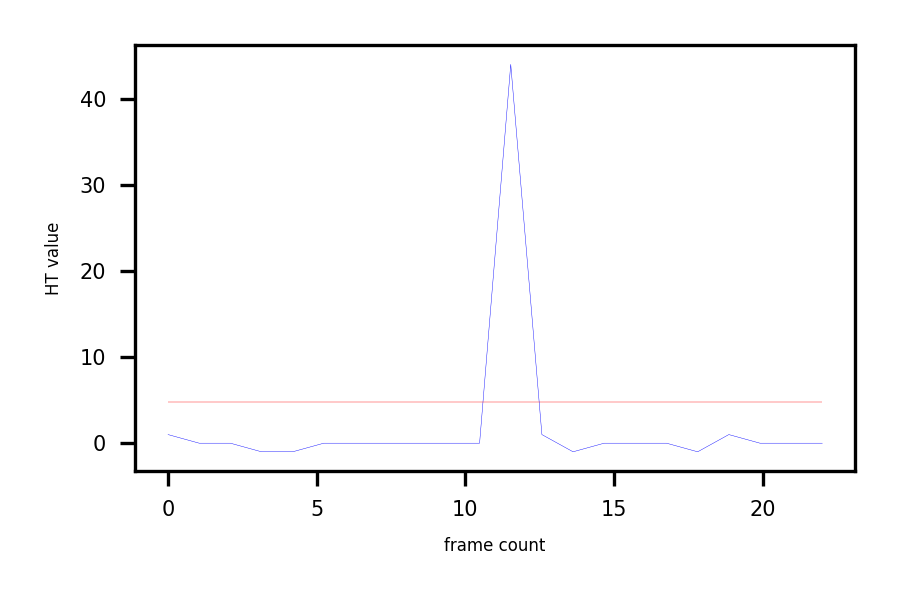

In [26]:
#some visualization
fig, ax = plt.subplots(figsize=(3.0,2.0), dpi=300)
ax.xaxis.set_tick_params(labelsize=5)
ax.yaxis.set_tick_params(labelsize=5)
plt.xlabel('frame count', fontsize = 4)
plt.ylabel('HT value', fontsize=4)
ax.plot(np.linspace(0,np.size(Ht_max),np.size(Ht_max)),Ht_max,c='b',linewidth=0.1)
ax.hlines(D,0,np.size(Ht_max),colors='r',linewidth=0.1)
fig.tight_layout()

plt.savefig('SSA400_meteor_event_peak.png')

In [24]:
#possible track length analysis, similar as previous
Lmax = np.asarray(lmax)
kernels = 200
L_max = Lmax[:,2] - sp.median_filter(Lmax[:,2], kernels)
D = 10*np.sqrt(sp.median_filter(L_max**2, kernels))

D = np.max(D)

lm = np.where(L_max > D)

if np.size(lm)>0:
    print(L_max[lm])
    for k in range(np.size(lm)):
        print(filelist[lm[0][k]])

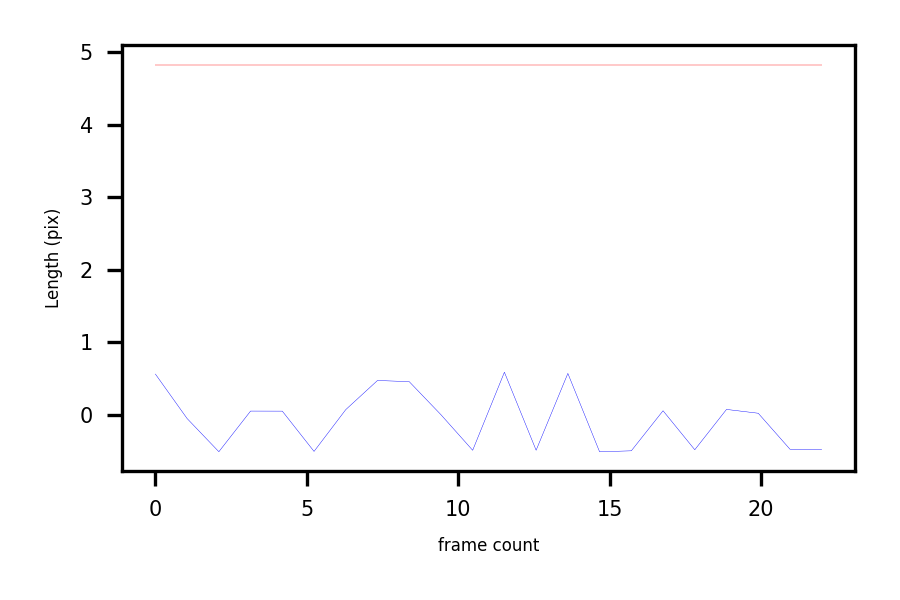

In [25]:
# visualization: there are no tracks
fig, ax = plt.subplots(figsize=(3.0,2.0), dpi=300)
ax.xaxis.set_tick_params(labelsize=5)
ax.yaxis.set_tick_params(labelsize=5)
plt.xlabel('frame count', fontsize = 4)
plt.ylabel('Length (pix)', fontsize=4)
ax.plot(np.linspace(0,np.size(L_max),np.size(L_max)),L_max,c='b',linewidth=0.1)
ax.hlines(D,0,np.size(L_max),colors='r',linewidth=0.1)
fig.tight_layout()